In [1]:
%matplotlib inline
import os
import re
import io
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [2]:
%run param.py

In [3]:
PATH_FLUX = os.path.join(DIR_FORTRAN, 'output_flux.dat')
PATH_COOLR = os.path.join(DIR_FORTRAN, 'output_coolr.dat')
PATH_WFLUX = os.path.join(DIR_FORTRAN, 'output_wflux.dat')
PATH_WCOOLR = os.path.join(DIR_FORTRAN, 'output_wcoolr.dat')

DS_FLUX = load_lblnew_output_file(PATH_FLUX)
DS_COOLR = load_lblnew_output_file(PATH_COOLR)
DS_WFLUX = load_lblnew_output_file(PATH_WFLUX)
DS_WCOOLR = load_lblnew_output_file(PATH_WCOOLR)

In [4]:
def load_lblnew_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['igg', 'g', 'pressure']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    ds = xr.Dataset.from_dataframe(df)
    return ds

In [5]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results

In [6]:
def script_show_lblnew_input():
    with open(os.path.join(DIR_FORTRAN, 'lblnew.f'), 
              mode='r', encoding='utf-8') as f:
        c = f.read()
    
    param = get_input_params(c, sorted(innames()))
    param = ['band = {}'.format(PARAM['band'])] + param
    param = ['molecule = {}'.format(PARAM['molecule'])] + param
    
    print('\n\n'.join(param))

In [7]:
def pltdata_cooling(ds_coolr=None, ds_wcoolr=None):
    data = [{'label': 'CRD', 
             'linestyle': '-', 'color': 'blue', 'marker': None,
             'srs': ds_coolr['coolr']},
            {'label': 'WGT igg=1', 
             'linestyle': '--', 'color': 'g', 'marker': None,
             'srs': ds_wcoolr['coolr'].sel(igg=1)}, 
             {'label': 'WGT igg=10',
            'linestyle': '--', 'color': 'r', 'marker': None,
            'srs': ds_wcoolr['coolr'].sel(igg=10)}]
    return data



In [8]:
def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 2,
                 'grid': True,
                 'alpha': .7}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():

    matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'grey',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

    pltdata = pltdata_cooling(ds_coolr=DS_COOLR, ds_wcoolr=DS_WCOOLR)

    fig, axs = plt_cooling(pltdata=pltdata)
    
    display.display(fig)
    print('Figure: Cooling rate profile comparison.')
    
    plt.close(fig)

In [9]:
def tbdata_flux(ds_flux=None, ds_wflux=None):
    ilevels = [0, -1]
    
    def fmt(ds):
        return ds.isel(pressure=ilevels)\
                 .to_dataframe()\
                 .set_index('level', append=True)
    
    benchmark = {'label': 'CRD',
                 'df': fmt(ds_flux)}
    
    tbs = [{'label': 'WGT igg=1',
            'df': fmt(ds_wflux.sel(igg=1)).drop('igg', axis=1)},
           {'label': 'WGT igg=10',
            'df': fmt(ds_wflux.sel(igg=10)).drop('igg', axis=1)}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data



In [10]:
def tb_flux(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table:', 'TOA and SFC flux.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        display.display(d['df'] - d0['df'])
        print('Table:', 'TOA and SFC flux.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)

        
def script_tb_flux():
    data = tbdata_flux(ds_flux=DS_FLUX, ds_wflux=DS_WFLUX)
    tb_flux(tbdata=data)
    


In [11]:
def tbdata_cooling(ds_coolr=None, ds_wcoolr=None):
    ilayers = [0, -1]
    
    def fmt(ds):
        return ds.isel(pressure=ilayers)\
                 .to_dataframe()\
                 .set_index('layer', append=True)
    
    benchmark = {'label': 'CRD',
                 'df': fmt(ds_coolr)}
    
    tbs = [{'label': 'WGT igg=1',
            'df': fmt(ds_wcoolr.sel(igg=1)).drop('igg', axis=1)},
           {'label': 'WGT igg=10',
            'df': fmt(ds_wcoolr.sel(igg=10)).drop('igg', axis=1)}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data   




In [12]:

def tb_cooling(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table:', 'TOA and SFC cooling rate.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        display.display(d['df'] - d0['df'])
        print('Table:', 'TOA and SFC cooling rate.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)    
        
        
        
def script_tb_cooling():
    data = tbdata_cooling(ds_coolr=DS_COOLR, ds_wcoolr=DS_WCOOLR)
    tb_cooling(tbdata=data)

In [13]:
def script():
    
    def show_html(s):
        display.display(display.HTML(s))
        
    def show_markdown(s):
        display.display(display.Markdown(s))
    
    
    show_markdown(climahtml.getMarkdown_sectitle('Input parameters'))
    script_show_lblnew_input()

    S_PLT_COOLING = 'Cooling Rate Profiles'
    S_TB_FLUX = 'Flux Comparison'
    S_TB_COOLING = 'Cooling Rate Comparison'

    # TOC
    show_markdown(climahtml.getMarkdown_sectitle('Table of Content'))
    show_html(climahtml.getHTML_hrefanchor(S_PLT_COOLING))
    show_html(climahtml.getHTML_hrefanchor(S_TB_FLUX))
    show_html(climahtml.getHTML_hrefanchor(S_TB_COOLING))

    # Cooling Rate Profiles
    show_html(climahtml.getHTML_idanchor(S_PLT_COOLING))
    show_markdown(climahtml.getMarkdown_sectitle(S_PLT_COOLING))
    script_plt_cooling()
    
    # Flux Comparison
    show_html(climahtml.getHTML_idanchor(S_TB_FLUX))
    show_markdown(climahtml.getMarkdown_sectitle(S_TB_FLUX))
    script_tb_flux()
    
    # Cooling Rate Comparison
    show_html(climahtml.getHTML_idanchor(S_TB_COOLING))
    show_markdown(climahtml.getMarkdown_sectitle(S_TB_COOLING))
    script_tb_cooling()
    



# Input parameters

molecule = ['h2o', 'co2']

band = 3c

dv = 0.005

nband = 80

nv = 200

option_wgt_flux =2

option_wgt_k =1

tsfc =257

vstar = 720

atmosphere_profiles/saw75.pro


# Table of Content

# Cooling Rate Profiles

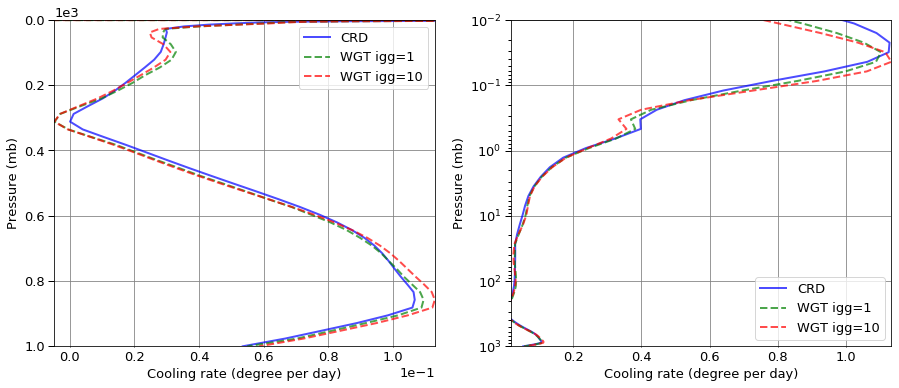

Figure: Cooling rate profile comparison.


# Flux Comparison

,,sfu,sfd,fnet
pressure,level,,,
0.0,1,-16.336207,0.000000,-16.336207
1013.0,76,-18.921523,9.185874,-9.735648


Table: TOA and SFC flux. CRD


,,sfu,sfd,fnet
pressure,level,,,
0.0,1,-16.195225,0.000000,-16.195225
1013.0,76,-18.921523,9.313635,-9.607888


Table: TOA and SFC flux. WGT igg=1


,,sfu,sfd,fnet
pressure,level,,,
0.0,1,-16.263610,0.000000,-16.263610
1013.0,76,-18.921523,9.319431,-9.602092


Table: TOA and SFC flux. WGT igg=10


,,sfu,sfd,fnet
pressure,level,,,
0.0,1,0.140982,0.00000,0.140982
1013.0,76,0.000000,0.12776,0.127760


Table: TOA and SFC flux. (WGT igg=1) - (CRD)


,,sfu,sfd,fnet
pressure,level,,,
0.0,1,0.072597,0.000000,0.072597
1013.0,76,0.000000,0.133556,0.133556


Table: TOA and SFC flux. (WGT igg=10) - (CRD)


# Cooling Rate Comparison

,,coolr
pressure,layer,
0.000312,1,0.114469
1001.112500,75,0.053513


Table: TOA and SFC cooling rate. CRD


,,coolr
pressure,layer,
0.000312,1,-0.004789
1001.112500,75,0.054913


Table: TOA and SFC cooling rate. WGT igg=1


,,coolr
pressure,layer,
0.000312,1,-0.048681
1001.112500,75,0.058598


Table: TOA and SFC cooling rate. WGT igg=10


,,coolr
pressure,layer,
0.000312,1,-0.119258
1001.112500,75,0.001399


Table: TOA and SFC cooling rate. (WGT igg=1) - (CRD)


,,coolr
pressure,layer,
0.000312,1,-0.163150
1001.112500,75,0.005084


Table: TOA and SFC cooling rate. (WGT igg=10) - (CRD)


In [14]:
script()

In [15]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')